#KenKen Puzzle Generator Notebook

##Installations

In [ ]:
!pip install z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 49.3 MB/s eta 0:00:00


In [ ]:
from z3 import *
import numpy as np
import math
import random
import time

##Solving a KenKen wtih Z3 SAT

In [ ]:
def parse_block_constraints(puzzle, cells):
    constraints = []
    for block in puzzle:
        op = block["op"]
        target = block["target"]
        vars_in_block = [cells[i][j] for i, j in block["cells"]]
        if op == "":
            constraints.append(vars_in_block[0] == target)
        elif op == "add":
            constraints.append(Sum(vars_in_block) == target)
        elif op == "mul":
            product = vars_in_block[0]
            for v in vars_in_block[1:]:
                product *= v
            constraints.append(product == target)
        elif op == "sub" and len(vars_in_block) == 2:
            a, b = vars_in_block
            constraints.append(Or(a - b == target, b - a == target))
        elif op == "div" and len(vars_in_block) == 2:
            a, b = vars_in_block
            constraints.append(Or(a / b == target, b / a == target))
        else:
            raise ValueError(f"Unsupported operation or malformed block: {block}")
    return constraints


In [ ]:
def evaluate_puzzle(puzzle, size):
  X = [ [ Int("x_%s_%s" % (i+1, j+1)) for j in range(size) ]
      for i in range(size) ]
  cells_c  = [ And(1 <= X[i][j], X[i][j] <= size)
              for i in range(size) for j in range(size) ]
  rows_c   = [ Distinct(X[i]) for i in range(size) ]
  cols_c   = [ Distinct([ X[i][j] for i in range(size) ])
              for j in range(size) ]
  constraints = cells_c + rows_c + cols_c + parse_block_constraints(puzzle, X)
  instance = [[0] * size] * size
  instance = [ If(instance[i][j] == 0,
                  True,
                  X[i][j] == instance[i][j])
               for i in range(size) for j in range(size) ]
  s = Solver()
  problem = constraints + instance
  s.add(problem)
  if s.check() == sat:
    m = s.model()
    solution = [ [ m.evaluate(X[i][j]) for j in range(size) ]
      for i in range(size) ]
    return solution
  else:
    print("failed to solve: constraints unsatisfiable")
    return None

##Generating an nxn KenKen

In [ ]:
def generate_sizes(grid_size, num_cages, max_cage_size, max_singletons):
  cage_sizes = []
  singleton_count = 0
  for _ in range(num_cages-1):
    cage_size = np.random.randint(1, max_cage_size+1)

    if cage_size == 1:
      if singleton_count >= max_singletons-1:
        cage_size = np.random.randint(2, max_cage_size+1)
      else:
        singleton_count += 1

    cage_sizes.append(cage_size)

  if sum(cage_sizes) < grid_size**2 and (grid_size**2 - sum(cage_sizes)) <= max_cage_size:
    cage_sizes.append(grid_size**2 - sum(cage_sizes))

  else:
    return None
  return cage_sizes

In [ ]:
def generate_solution_grid(n):
    solver = Solver()
    cells = [[Int(f'cell_{i}_{j}') for j in range(n)] for i in range(n)]

    for i in range(n):
        for j in range(n):
            solver.add(And(1 <= cells[i][j], cells[i][j] <= n))

    rows = list(range(n))
    cols = list(range(n))
    random.shuffle(rows)
    random.shuffle(cols)

    for i in rows:
        solver.add(Distinct(cells[i]))

    for j in cols:
        solver.add(Distinct([cells[i][j] for i in range(n)]))

    if solver.check() == sat:
        model = solver.model()
        return [[model[cells[i][j]].as_long() for j in range(n)] for i in range(n)]
    else:
        raise Exception("Failed to generate solution grid")

In [ ]:
def choose_unassigned(grid_size, assigned):
  if grid_size**2 == len(assigned):
    return None
  while True:
    row = np.random.randint(0, grid_size)
    col = np.random.randint(0, grid_size)
    if [row, col] not in assigned:
      return [row, col]

In [ ]:
choose_unassigned(4, [[0, 0], [0, 1]])

[3, 3]

In [ ]:
def get_target(cage, grid):
  if cage["op"] == "sub":
    return abs(grid[cage["cells"][0][0]][cage["cells"][0][1]] - grid[cage["cells"][1][0]][cage["cells"][1][1]])
  elif cage["op"] == "div":

    return max((grid[cage["cells"][0][0]][cage["cells"][0][1]] / grid[cage["cells"][1][0]][cage["cells"][1][1]]),
                (grid[cage["cells"][1][0]][cage["cells"][1][1]] / grid[cage["cells"][0][0]][cage["cells"][0][1]]))


  elif cage["op"] == "mul":
    s = 1
    for cell in cage["cells"]:
      s *= grid[cell[0]][cell[1]]
    return s
  else:
    s = 0
    for cell in cage["cells"]:
      s += grid[cell[0]][cell[1]]
    return s

In [ ]:
def get_unassigned_neighbors(grid_size, assigned, cell):
  row = cell[0]
  col = cell[1]
  neighbors = []
  if row > 0:
    neighbors.append([row-1, col])
  if row < grid_size-1:
    neighbors.append([row+1, col])
  if col > 0:
    neighbors.append([row, col-1])
  if col < grid_size-1:
    neighbors.append([row, col+1])
  unassigned_neighbors = [neighbor for neighbor in neighbors if neighbor not in assigned]
  return unassigned_neighbors

In [ ]:
def make_cage(puzzle, grid, grid_size, assigned, cage_size, index):
  to_assign = []
  start_cell = choose_unassigned(grid_size, assigned)

  puzzle.append({"cells": [], "op": "", "target": 0})

  num_attempts = 10

  if not start_cell:
    return

  if cage_size == 1:
    puzzle[index]["cells"].append(start_cell)
    assigned.append(start_cell)
    puzzle[index]["target"] = grid[start_cell[0]][start_cell[1]]
    return

  puzzle[index]["cells"].append(start_cell)
  to_assign.append(start_cell)
  while len(puzzle[index]["cells"]) < cage_size:
    neighbors = []
    for cell in puzzle[index]["cells"]:

      neighbors.extend(get_unassigned_neighbors(grid_size, assigned+to_assign, [cell[0], cell[1]] ))


    if not neighbors:
      if num_attempts == 0:
        puzzle[index]["cells"] = []
        #print("Attempts to find neighbors maxed out")
        return

      num_attempts -= 1
      start_cell = choose_unassigned(grid_size, assigned)
      puzzle[index]["cells"] = [start_cell]
      to_assign = [start_cell]
      continue
      #return


    neighbor = neighbors[np.random.randint(0, len(neighbors))]
    puzzle[index]["cells"].append(neighbor)
    to_assign.append(neighbor)


  assigned += to_assign

  puzzle[index]["op"] = generate_ops(puzzle[index], grid)
  puzzle[index]["target"] = get_target(puzzle[index], grid)




In [ ]:
def generate_ops(cage, grid):
  cage_size = len(cage["cells"])
  options = []

  if cage_size == 1:
    return ""

  if cage_size == 2:
    if grid[cage["cells"][0][0]][cage["cells"][0][1]] % grid[cage["cells"][1][0]][cage["cells"][1][1]]==0 or grid[cage["cells"][1][0]][cage["cells"][1][1]] % grid[cage["cells"][0][0]][cage["cells"][0][1]]==0:
      options+=["div", "div"]
    options+=["sub", "mul", "add"]
  else:
    options = ["mul", "add"]

  return np.random.choice(options)




In [ ]:
def generate_puzzle(grid_size, max_cage_size, max_singletons):
  num_cages = np.random.randint(math.ceil(grid_size**2 / max_cage_size), min((max_singletons+((grid_size**2 - max_singletons)//2) + max_singletons), grid_size**2))



  cage_sizes = generate_sizes(grid_size, num_cages, max_cage_size, max_singletons)

  while not cage_sizes:
    num_cages = np.random.randint(math.ceil(grid_size**2 / max_cage_size), min((max_singletons+((grid_size**2 - max_singletons)//2) + max_singletons), grid_size**2))
    cage_sizes = generate_sizes(grid_size, num_cages, max_cage_size, max_singletons)

  grid = generate_solution_grid(grid_size)
  puzzle = []



  assigned = []
  for index in range(num_cages):
    make_cage(puzzle, grid, grid_size, assigned, cage_sizes[index], index)
    if puzzle[index]["cells"] == []:
      return None

  return puzzle

In [ ]:
def generate_puzzle_set(num_puzzles, grid_size, max_cage_size, max_singletons):
  puzzle_set = []
  solution_set = []
  num_puzzles_generated = 0
  while num_puzzles_generated < num_puzzles:
    puzzle = generate_puzzle(grid_size, max_cage_size, max_singletons)
    if puzzle:
      solution = evaluate_puzzle(puzzle, grid_size)
      if solution:
        puzzle_set.append(puzzle)
        solution_set.append(solution)
        num_puzzles_generated += 1
        print(f"Generated puzzle {num_puzzles_generated}/{num_puzzles}")
      else:
        print(puzzle)

    #time.sleep(1)
  return puzzle_set, solution_set

##Demo

In [ ]:
generate_puzzle_set(1, 4, 3, 2)

Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Failed to generate cage sizes
Generated puzzle 1/1


([[{'cells': [[0, 3], [1, 3], [0, 2]], 'op': np.str_('add'), 'target': 7},
   {'cells': [[2, 0], [2, 1], [3, 0]], 'op': np.str_('add'), 'target': 9},
   {'cells': [[2, 3]], 'op': '', 'target': 2},
   {'cells': [[0, 1], [1, 1]], 'op': np.str_('mul'), 'target': 8},
   {'cells': [[1, 0], [0, 0]], 'op': np.str_('add'), 'target': 4},
   {'cells': [[1, 2], [2, 2]], 'op': np.str_('div'), 'target': 3.0},
   {'cells': [[3, 3], [3, 2]], 'op': np.str_('sub'), 'target': 1},
   {'cells': [[3, 1]], 'op': '', 'target': 1}]],
 [[[3, 4, 2, 1], [1, 2, 3, 4], [4, 3, 1, 2], [2, 1, 4, 3]]])

##Generate Dataset

In [ ]:
puzzles_full = {}
solutions_full = {}
runtimes = {}

for size in range(3, 5):
    print("Grid Size =", size)
    start = time.time()
    p, s = generate_puzzle_set(100, size, 3, 2)
    end = time.time()
    puzzles_full[size] = p
    solutions_full[size] = s
    runtimes[size] = end - start

for size in range(5, 7):
    print("Grid Size =", size)
    start = time.time()
    p, s = generate_puzzle_set(30, size, 4, 2)
    end = time.time()
    puzzles_full[size] = p
    solutions_full[size] = s
    runtimes[size] = end - start

for size in range(7, 8):
    print("Grid Size =", size)
    start = time.time()
    p, s = generate_puzzle_set(30, size, 4, 2)
    end = time.time()
    puzzles_full[size] = p
    solutions_full[size] = s
    runtimes[size] = end - start

Grid Size = 7
Generated puzzle 1/30
Generated puzzle 2/30
Generated puzzle 3/30
Generated puzzle 4/30
Generated puzzle 5/30
Generated puzzle 6/30
Generated puzzle 7/30
Generated puzzle 8/30
Generated puzzle 9/30
Generated puzzle 10/30
Generated puzzle 11/30
Generated puzzle 12/30
Generated puzzle 13/30
Generated puzzle 14/30
Generated puzzle 15/30
Generated puzzle 16/30
Generated puzzle 17/30
Generated puzzle 18/30
Generated puzzle 19/30
Generated puzzle 20/30
Generated puzzle 21/30
Generated puzzle 22/30
Generated puzzle 23/30
Generated puzzle 24/30
Generated puzzle 25/30
Generated puzzle 26/30
Generated puzzle 27/30
Generated puzzle 28/30
Generated puzzle 29/30
Generated puzzle 30/30


##Plot Run Times




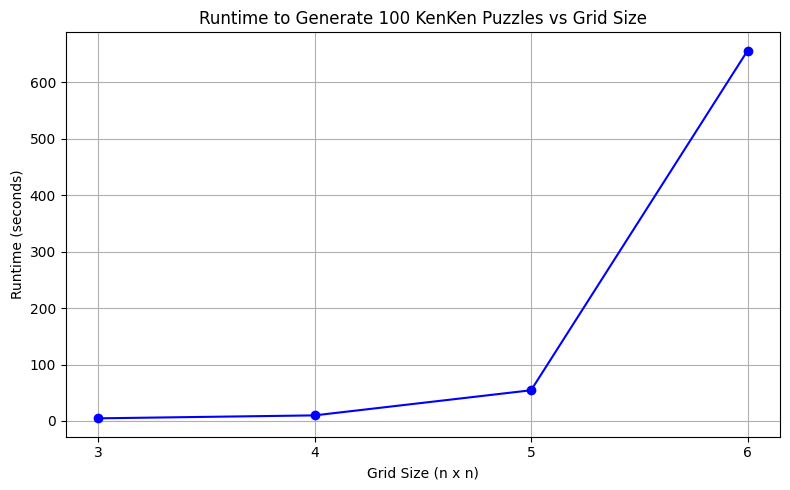

In [ ]:
import matplotlib.pyplot as plt

sizes = sorted(runtimes.keys())
times = [runtimes[s] for s in sizes]

plt.figure(figsize=(8, 5))
plt.plot(sizes, times, marker='o', linestyle='-', color='blue')
plt.title("Runtime to Generate 100 KenKen Puzzles vs Grid Size")
plt.xlabel("Grid Size (n x n)")
plt.ylabel("Runtime (seconds)")
plt.grid(True)
plt.xticks(sizes)
plt.tight_layout()
plt.show()

##Save dataset

In [ ]:
import json

drive_folder = "./puzzles/"

import os

# Save puzzles and solutions
with open(os.path.join(drive_folder, "puzzles_dict.json"), "w") as f:
    json.dump(puzzles_full, f, indent=2)